In [ ]:
!nvidia-smi

Wed May 26 18:37:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |   1442MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Homework 4: DCGAN

**Due: 6/8 11:59 pm, 2021**

(Code is modified from pytorch official DCGAN [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html))

Remember to check the runtime of your notebook is GPU. Expected training time is about 20 ~ 40 minutes using GPU (depends on Colab).


Reference from AIMS, NTHU

## Problems

### Q1. Compare the visualization images after step 0, 200, 1000, 2500, 5000.


Step	Describe Image

0	  雜訊(Noise)，看不懂內容。

200 	色彩較為豐富，有人影。

1000	 鮮豔的色彩，可以看出人的輪廓，但模糊。

2500 	圖片較清晰，但大概是影片的144p→240p的感覺。

5000 	圖片更加清晰，從240p→360p了。



### Q2. Why can't we see the typical loss descreasing in generator/discriminator's loss curve?
GAN的Loss curve跟CNN的完全不一樣，CNN的是一條慢慢往下的線，而GAN前面的部分可以看到落差非常大，那是因為GAN的Generator和Discriminator是一種互相競爭、互相拔河的神經網路，所以會造成此現象。


### Q3. How to generate fake images after training? Please use our trained generator to generate fake images using following distributions:
 我們透過一開始給的條件(C)和雜訊(Z)輸入到Generator裡面，即可生成出一張影像，而這張影像會再由Discriminator進行鑑定，判斷其是否為假的照片，假如是假的照片則會告訴Generator少了什麼，如:色彩、人物、解析度…等，藉由兩者不斷的競爭來增強模型生成出來的圖片。
1. $\mathcal{N}(0, 1)$: same as our training, the standard normal distribution
圖再報告裡面
2. $\mathcal{N}(-10, 1)$: normal distribution with `mean=-10, std=1`
圖再報告裡面
3. $\mathcal{U}(0, 1)$: uniform distribution in range `[0, 1]`
圖再報告裡面
Each distribution should generate 128 fake images (a mini-batch). The fake images should be embedded in your notebook. You need to write some code in this problem.

(Hint: The last cell of this notebook is the solution to Q3.1)

### Q4. Why the result of Q3.2 looks so weird, i.e., Why our generator fails at generating images using latent vector following distribution $\mathcal{N}(-10, 1)$?
通常常態分佈訊號輸入的範圍越大，則輸出的質量則會較低。
這邊我額外又多做了四次數據驗證分別是Normal distribution(-5,1)、Normal distribution(-3,1)、Normal distribution(-2,1)、Normal distribution(-1,1)。
比較圖、比較表在報告裡面


### Q5. Why the result images of Q3.3 looks so similar to each other?

圖片跟內容在報告裡面


## Download Data and Import Libraries

In [ ]:
from pathlib import Path
from torchvision.datasets.utils import download_file_from_google_drive, extract_archive

zip_path = Path('./img_align_celeba.zip')
data_dir = Path('./data/')

if not zip_path.exists():
    download_file_from_google_drive('1L4ITJcEcvxQ3TqOknkYYUDoglGoylwHu', '.', str(zip_path))
if not data_dir.exists():
    extract_archive(str(zip_path), str(data_dir))

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Sampler, Dataset, Subset
from torch.utils.tensorboard import SummaryWriter

from torchvision.utils import make_grid
from torchvision import transforms as tsfm

import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path
from IPython import display

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True

## Custom Pytorch Dataset and Dataloader


A `Dataset` in Pytorch should have two methods:

1. `__len__`: return a integer indicating the size of the dataset
2. `__getitem__`: given an index `idx`, return the `idx`-th sample

In our case, the download data is structured as:
```
data/
    img_align_celeba/
        000001.jpg
        000002.jpg
        ...
```

We can simply find all the jpegs and load them into memory when needed. In common practice, dataset will receive one or more `torchvision.transforms` which transform the jpeg (loaded as `PIL.Image`) into pytorch tensor. 

`Dataloader` batchify the samples in dataset, i.e. builds mini-batch from the data return by dataset's `__getitem__` . We then iterate the `Dataloader` for training.

Usually `Dataloader` is finite and will run of mini-batches when we have seen all samples in `Dataset` once. However, to write our code easily, we can create an infinite `Sampler` that can guide the batchification process in `Dataloader` and make `Dataloader` supply mini-batches infinitely.

In [ ]:
class CelebA(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.img_paths = list(Path(root_dir).glob('*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        img = self.transform(img)
        return img


data = CelebA(data_dir / 'img_align_celeba', transform=tsfm.Compose([
    tsfm.Resize((64, 64)),
    tsfm.ToTensor(),
    tsfm.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
]))

print('#sample:', len(data))

#sample: 202599


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3, 64, 64])


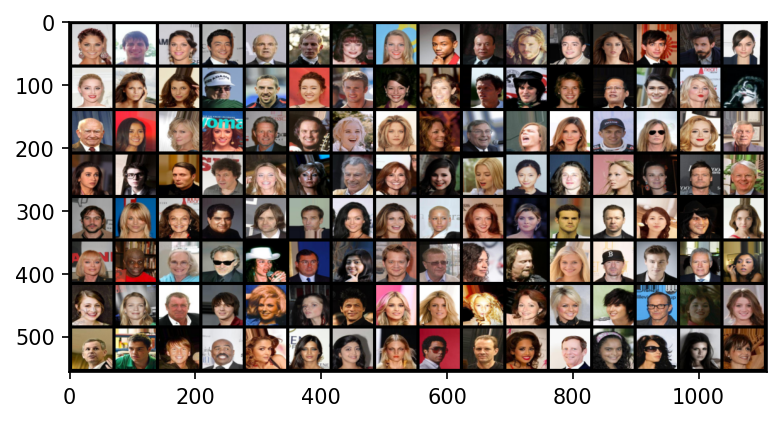

In [ ]:
class InfiniteSampler(Sampler):
    def __init__(self, data_source):
        super().__init__(data_source)
        self.N = len(data_source)

    def __iter__(self):
        while True:
            for idx in torch.randperm(self.N):
                yield idx

loader = iter(
    DataLoader(
        data, 
        batch_size=128, 
        num_workers=4, 
        sampler=InfiniteSampler(data)
    )
)

img_b = next(loader)    # retrieve a mini-batch
print(img_b.size())     # expected [128, 3, 64, 64]

# visualization
vis = tsfm.ToPILImage()(make_grid(img_b, nrow=16, padding=5, normalize=True))
fig, ax = plt.subplots(dpi=150)
ax.imshow(vis)
plt.show()

## Generator and Discriminator

To draw an vector following normal distribution $\mathcal{N}(\mu, \sigma^2)$ in pytorch, one can write:
```python
torch.normal(mean, std, shape) # shape is the desire dimension 
```
So `torch.normal(0.0, 1.0, [100])` will get an vector of size 100 with each element following $\mathcal{N}(0, 1)$.

In this implementation, we need to reshape latent vector `z` of shape `[100]` to `[100, 1, 1]` so that we can simplify some code in generator. Therefore, to make generator `G` create a mini-batch of fake images from standard normal distribution is

```python
fake_b = G(torch.normal(0.0, 1.0, (128, 100, 1, 1)))
# fake_b has shape [128, 3, H, W]
```

Don't forget the leading dimension 128! It means there are 128 samples in this mini-batch.


In [ ]:
nz = 100    # Size of z latent vector (i.e. size of generator input)
ngf = 64    # Size of feature maps in generator
ndf = 64    # Size of feature maps in discriminator
nc = 3      # Number of channels in the images. For color images this is 3

G = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(ngf * 8),
    nn.ReLU(True),
    # state size. (ngf*8) x 4 x 4
    nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 4),
    nn.ReLU(True),
    # state size. (ngf*4) x 8 x 8
    nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 2),
    nn.ReLU(True),
    # state size. (ngf*2) x 16 x 16
    nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf),
    nn.ReLU(True),
    # state size. (ngf) x 32 x 32
    nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
    nn.Tanh()
    # state size. (nc) x 64 x 64
)

D = nn.Sequential(
    # input is (nc) x 64 x 64
    nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf) x 32 x 32
    nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ndf * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*2) x 16 x 16
    nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ndf * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*4) x 8 x 8
    nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ndf * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*8) x 4 x 4
    nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

print(G)
print(D)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)
Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), 

## Training


In [ ]:
!rm -rf ./vis*

# Weight init, GAN is sensitive to initialized weight
G.apply(weight_init)
D.apply(weight_init)

# Move the model to GPU
device = 'cuda'
G = G.to(device)
D = D.to(device)

# Specify criterion (loss function) and optimizers
# Note that there are 2 optimizers, one for generator, one for discriminator.
criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Fixed latent vector used for visualization
fixed_latent = torch.randn(128, nz, 1, 1).to(device)

history = {
    'step': [],
    'lossG': [],
    'lossD': [],
}

# Train 5k steps. tqdm is for progress bar.
for step in tqdm(range(5000 + 1)):

    # 1. Train Discriminator

    # 1a. Clear all previous gradient
    optimizerD.zero_grad()
    
    # 1b. Forward + Backward with real images
    real_b = next(loader).to(device)                                # [128, 3, 64, 64]
    label_b = torch.ones(128).to(device)                            # [128]
    output_b = D(real_b).flatten()                                  # [128]
    lossD_real = criterion(output_b, label_b)                       # scalar
    lossD_real.backward()

    # 1c. Forward + Backward with fake images
    fake_b = G(torch.normal(0.0, 1.0, (128, nz, 1, 1)).to(device))  # [128, 3, 64, 64]
    label_b = torch.zeros(128).to(device)                           # [128]
    output_b = D(fake_b).flatten()                                  # [128]
    lossD_fake = criterion(output_b, label_b)                       # scalar
    lossD_fake.backward()

    # Now 1b's gradients and 1c's gradients are accumulated on each parameter.
    # 1d. Optimize
    optimizerD.step()


    # 2. Train Generator
    # Note that the label is ones
    # Since we want to fool discriminator as much as possible
    optimizerG.zero_grad()
    fake_b = G(torch.normal(0.0, 1.0, (128, nz, 1, 1)).to(device))  # [128, 3, 64, 64]
    input_b = fake_b                                                # [128, 3, 64, 64]
    label_b = torch.ones(128).to(device)                            # [128]
    output_b = D(input_b).flatten()                                 # [128]
    lossG = criterion(output_b, label_b)                            # scalar
    lossG.backward()
    optimizerG.step()
    
    lossG = lossG.item()
    lossD = lossD_real.item() + lossD_fake.item()
    history['step'].append(step)
    history['lossG'].append(lossG)
    history['lossD'].append(lossD)

    # 3. Logging
    if step % 50 == 0:
        # lossG = lossG.item()
        # lossD = lossD_real.item() + lossD_fake.item()
        print('Step {:04d}: lossG={:6.3f}, lossD={:6.3f}'.format(step, lossG, lossD))
        # history['step'].append(step)
        # history['lossG'].append(lossG)
        # history['lossD'].append(lossD)
    
        
    # 4. Visualization
    if step % 100 == 0:
        G.eval()
        vis = G(fixed_latent).detach().cpu()
        vis = make_grid(vis, nrow=16, padding=5, normalize=True)
        vis = tsfm.ToPILImage()(vis)
        vis.save('vis{:04d}.jpg'.format(step))
        G.train()

Step 0000: lossG= 4.791, lossD= 1.795
Step 0050: lossG=15.950, lossD= 0.240
Step 0100: lossG= 8.156, lossD= 0.188
Step 0150: lossG= 7.375, lossD= 0.565
Step 0200: lossG= 8.396, lossD= 0.943
Step 0250: lossG= 9.052, lossD= 2.021
Step 0300: lossG= 3.870, lossD= 0.719
Step 0350: lossG= 1.478, lossD= 0.699
Step 0400: lossG= 4.686, lossD= 0.469
Step 0450: lossG= 3.434, lossD= 0.492
Step 0500: lossG= 5.889, lossD= 0.354
Step 0550: lossG= 4.564, lossD= 0.829
Step 0600: lossG= 4.648, lossD= 0.513
Step 0650: lossG= 5.293, lossD= 0.713
Step 0700: lossG= 2.989, lossD= 1.218
Step 0750: lossG= 4.881, lossD= 1.438
Step 0800: lossG= 2.708, lossD= 0.595
Step 0850: lossG= 3.313, lossD= 0.635
Step 0900: lossG= 5.264, lossD= 0.292
Step 0950: lossG= 2.536, lossD= 0.377
Step 1000: lossG= 2.226, lossD= 0.778
Step 1050: lossG= 3.431, lossD= 0.426
Step 1100: lossG= 1.741, lossD= 1.926
Step 1150: lossG= 3.426, lossD= 0.459
Step 1200: lossG= 5.560, lossD= 0.612
Step 1250: lossG= 3.180, lossD= 0.839
Step 1300: l

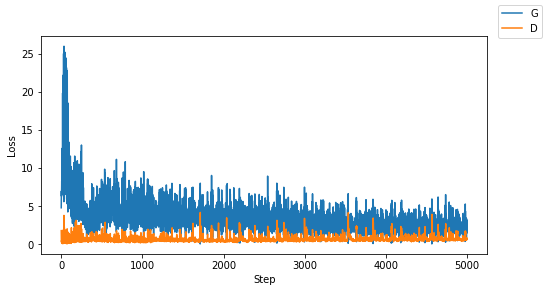

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history['step'], history['lossG'], label='G')
ax.plot(history['step'], history['lossD'], label='D')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
fig.legend()
plt.show()

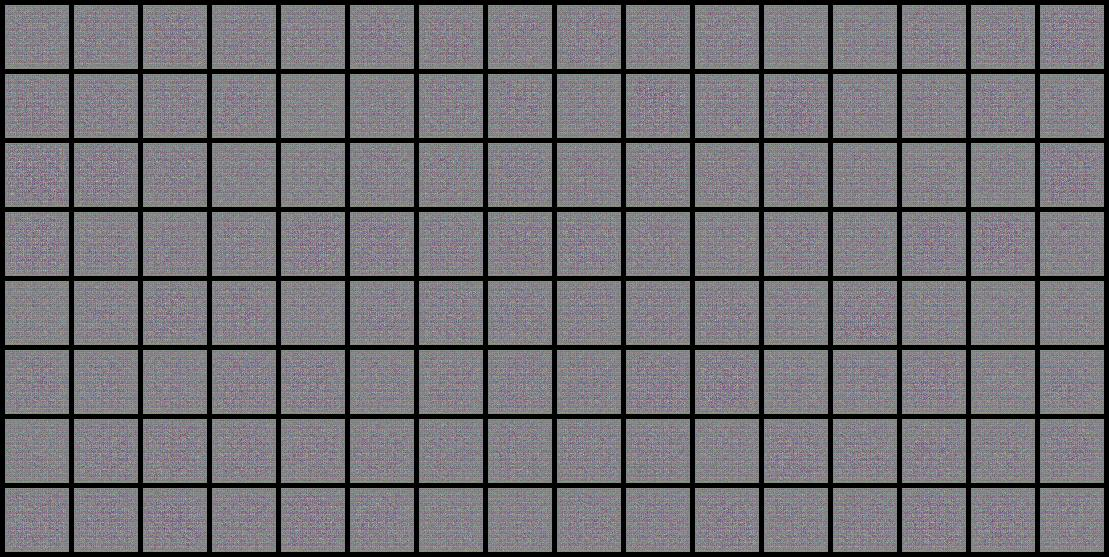

In [ ]:
display.Image('vis0000.jpg')

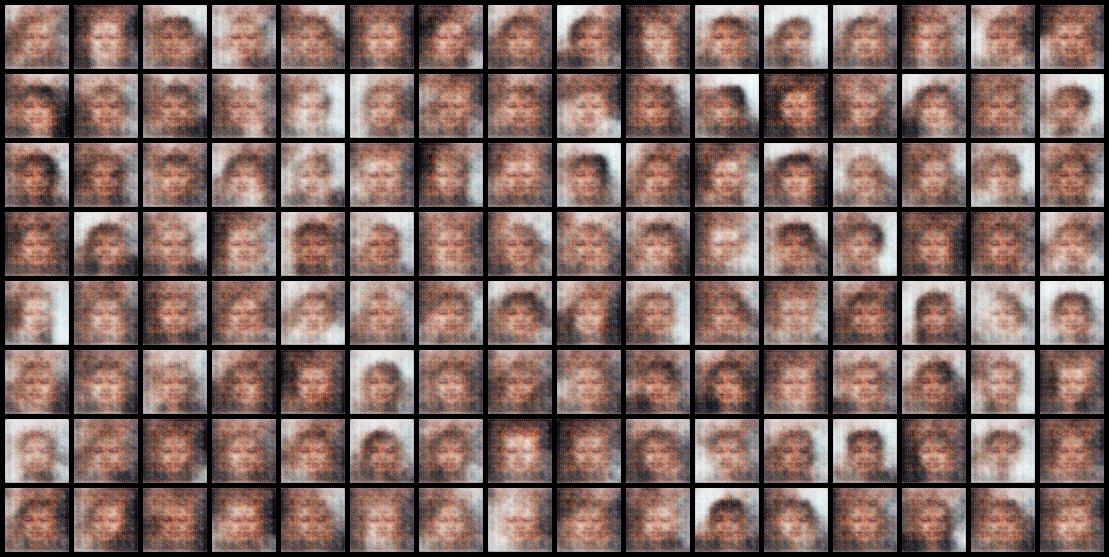

In [ ]:
display.Image('vis0200.jpg')

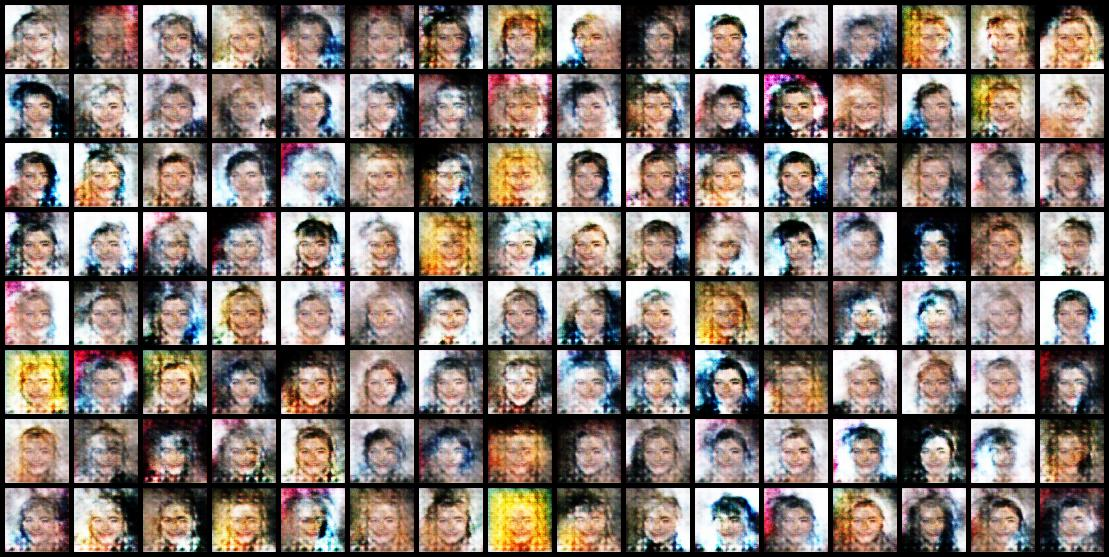

In [ ]:
display.Image('vis1000.jpg')

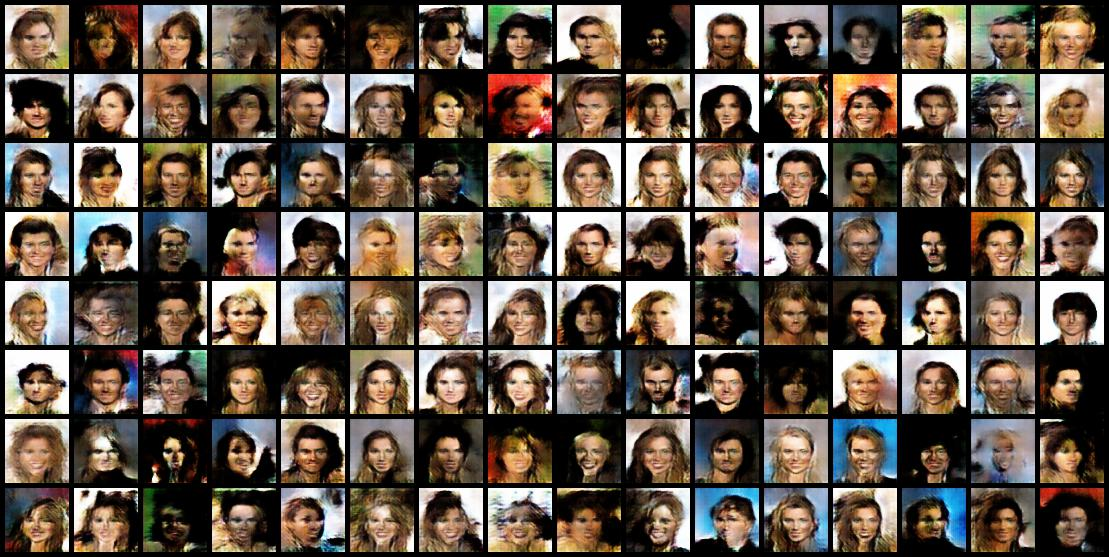

In [ ]:
display.Image('vis2500.jpg')

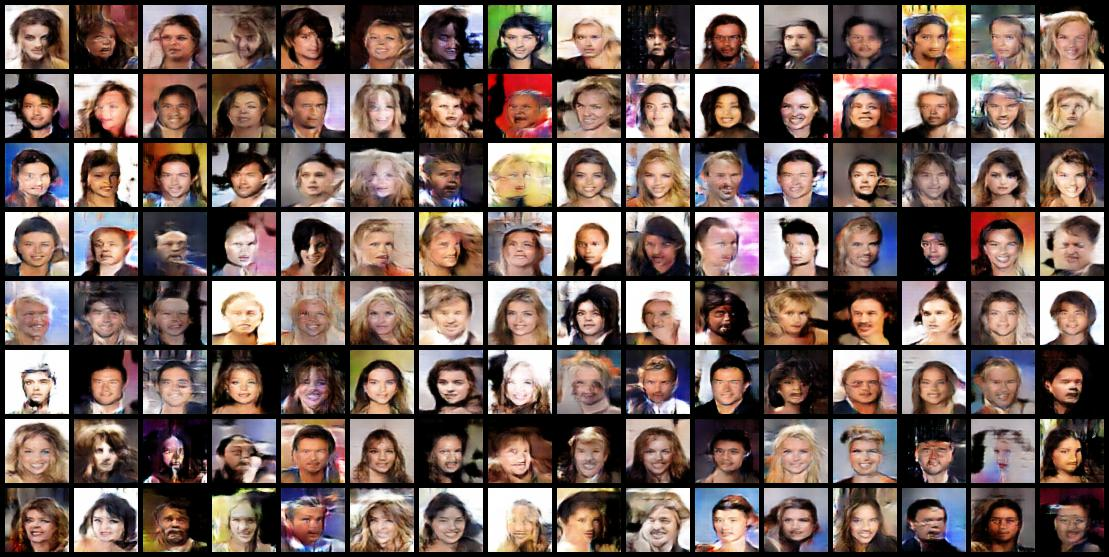

In [ ]:
display.Image('vis5000.jpg')

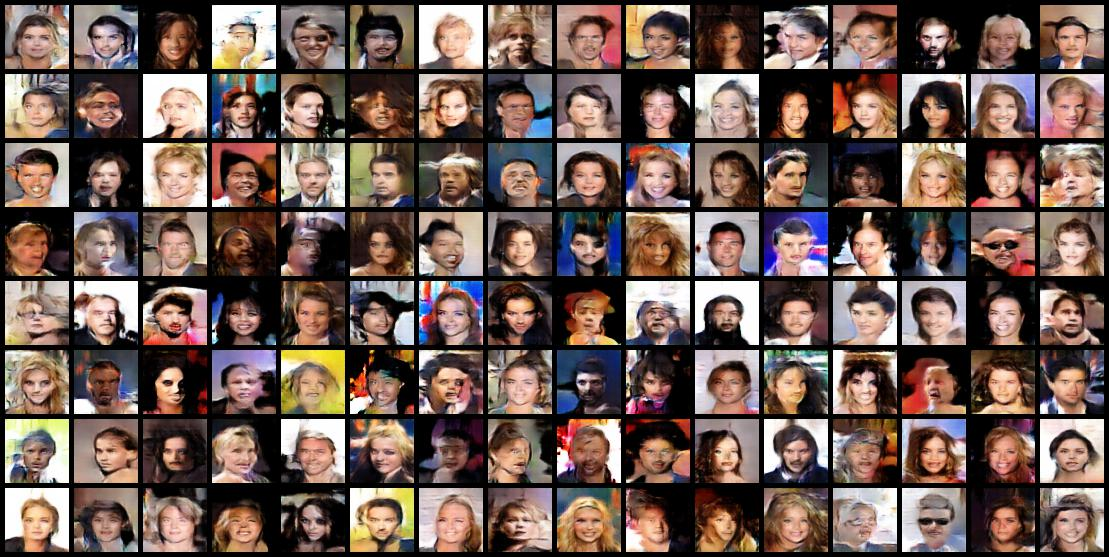

In [ ]:
with torch.no_grad():
    G.eval()

    fake_b = G(torch.normal(0.0, 1.0, (128, nz, 1, 1)).to(device)).to('cpu')
    vis = make_grid(fake_b, nrow=16, padding=5, normalize=True)
    vis = tsfm.ToPILImage()(vis)
    vis.save('fake_standard.jpg')

display.Image('fake_standard.jpg')

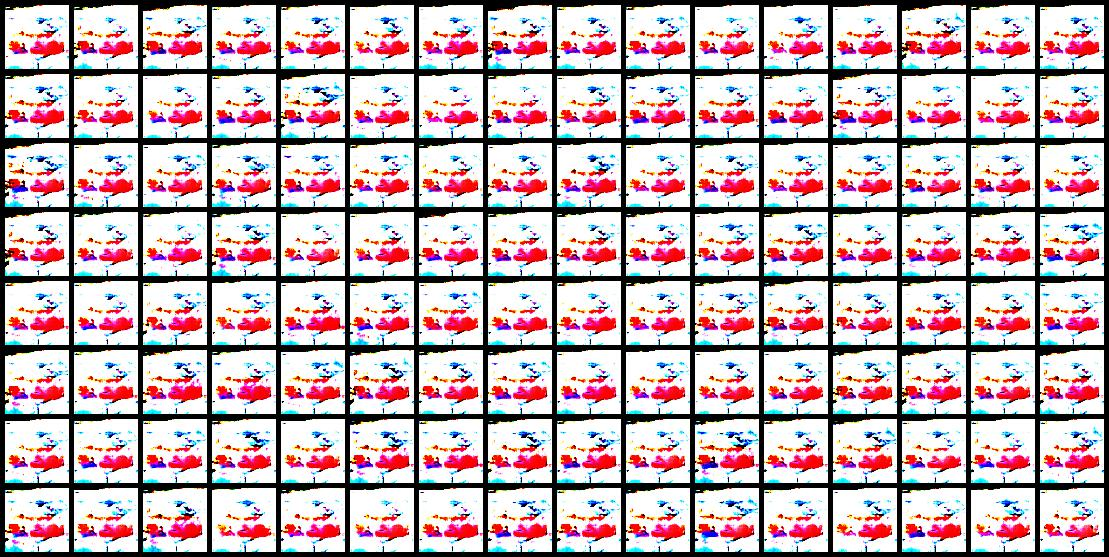

In [ ]:
with torch.no_grad():
    G.eval()

    fake_b = G(torch.normal(-10.0, 1.0, (128, nz, 1, 1)).to(device)).to('cpu')
    vis = make_grid(fake_b, nrow=16, padding=5, normalize=True)
    vis = tsfm.ToPILImage()(vis)
    vis.save('fake_standard.jpg')

display.Image('fake_standard.jpg')

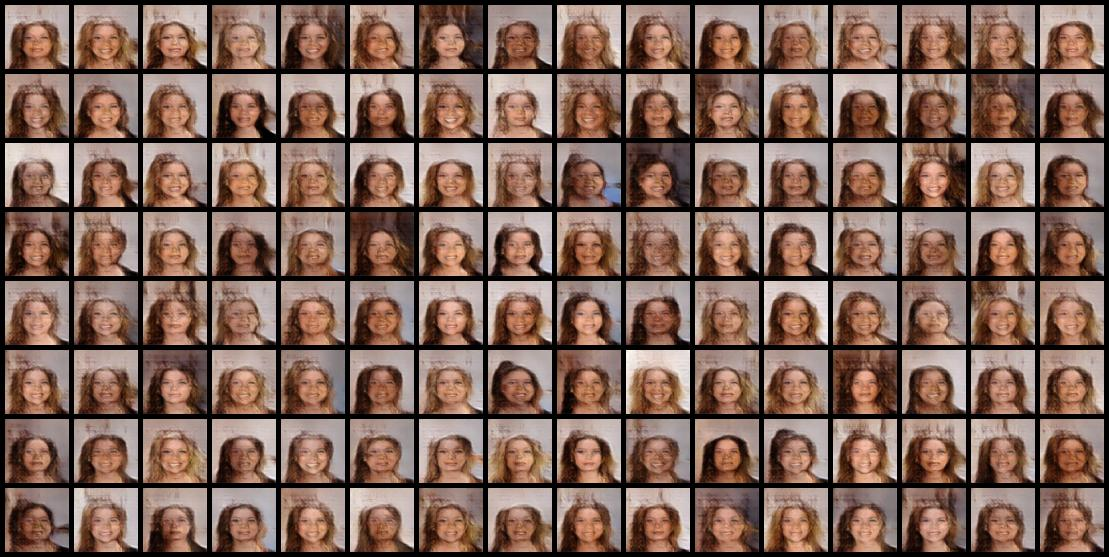

In [ ]:
with torch.no_grad():
    G.eval()

    fake_b = G(torch.rand((128, nz, 1, 1)).to(device)).to('cpu')
    vis = make_grid(fake_b, nrow=16, padding=5, normalize=True)
    vis = tsfm.ToPILImage()(vis)
    vis.save('fake_standard.jpg')

display.Image('fake_standard.jpg')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


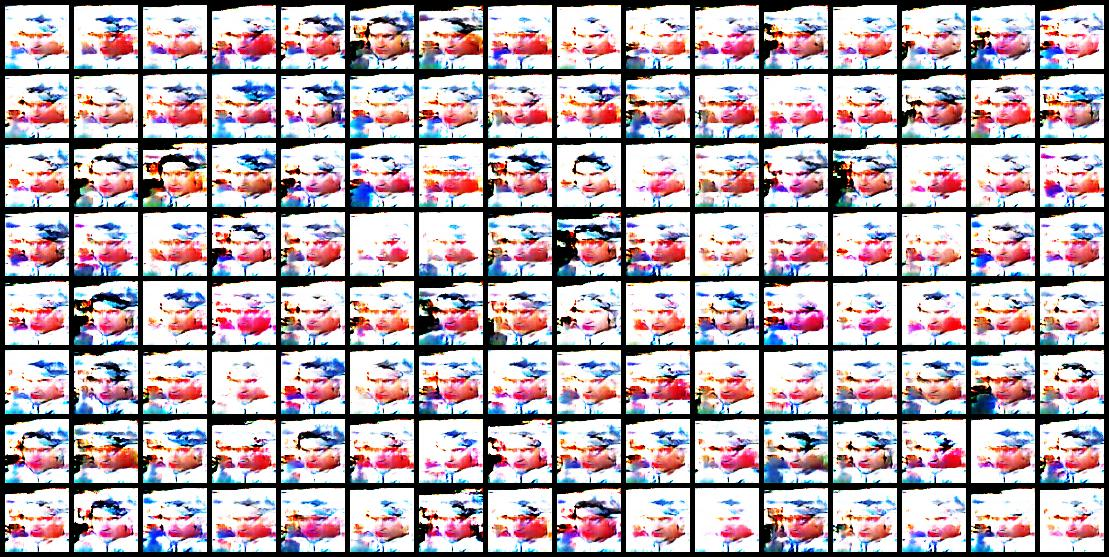

In [ ]:
with torch.no_grad():
    G.eval()

    fake_b = G(torch.normal(-3.0, 1.0, (128, nz, 1, 1)).to(device)).to('cpu')
    vis = make_grid(fake_b, nrow=16, padding=5, normalize=True)
    vis = tsfm.ToPILImage()(vis)
    vis.save('fake_standard.jpg')

display.Image('fake_standard.jpg')